# Importing Packages and Defining Helper Functions

In [1]:
# Used to get statistics for preprocessing
from osgeo import gdal


# import torch and other necessary modules from torch
# https://docs.google.com/document/d/1e3Ybe0KQFmSzbsqRl8o9f-PeWsv5nUrKLBrTgH-Ywsc/edit
import torch
import torch.nn as nn

# import torchvision and other necessary modules from torchvision 
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as figure
from sklearn.metrics import r2_score, mean_squared_error
from torch.utils.data import Dataset, DataLoader
import os
import math
from PIL import Image


#### Helper Functions / Classes

In [12]:
# Constants to use later in the script
PATH_TO_TILED_IMGS = "D:\Sentinel1\six-beam-directory"
SAR_REF = "./src/data/sentinel2/reprojectedWSG84.tiff"
BATCH_SIZE = 128            # How many random sampled tiles to pull for each iteration of training

# Label parser used when previewing the input data 
def parseLabel(filename: str):
    index, file = filename.split("-")
    basename = file.replace(".tiff", "")
    return (index, basename)

# Custom tiled dataset class
class SARTile(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_list = os.listdir(data_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image_path = os.path.join(self.data_dir, image_name)
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        index, image_name = parseLabel(image_name)
            
        return (image, float(image_name), index)

#### Loading Data + Setting Preprocessing Steps

In [13]:
# Reference to the SAR image that our dataset was tiled from
SAR = gdal.Open(SAR_REF)

# Calculating the global stats of the file to preprocess our tiles
tiffMin, tiffMax, tiffMean, tiffStDev = SAR.GetRasterBand(1).GetStatistics(0,1)

# IceSat beam data. Note: Labeling was done in the tiling script, this reading is just for stats.
beam_data = pd.read_csv("./src/data/icesat2/3BeamCoordinates+Extra.csv")
fbh_mean = beam_data[['gt1rFBH', 'gt1lFBH', 'gt2rFBH', 'gt2lFBH', 'gt3rFBH', 'gt3lFBH']].mean()         # Calculates the mean beam measure of each laser
fbh_mean = fbh_mean.mean()                                                                              # Calculates the mean of means
beam_data = None                                                                                        # Closes the df

# Defining the images as grayscale, converting it to a tensor, adding random flips and rotations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # We know the inputs are greyscale
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=tiffMean,
        std=tiffStDev
    )
])


#### Read Data and set Train/Test splits

3044
761


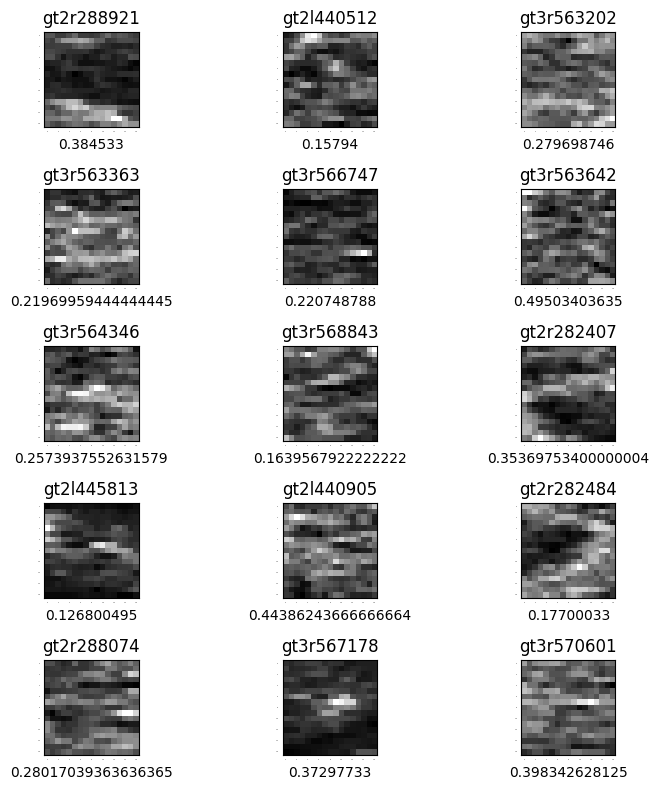

In [14]:
# Reading in the dataset using the custom class defined above
dataset = SARTile(data_dir = PATH_TO_TILED_IMGS, transform=transform)

# 80/20 split of train/test 
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(train_size)
print(test_size)
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

# prepare dataloader for training set and evaluation set
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

# Visualizing some of the testing data
fig, axs = plt.subplots(5, 3, figsize=(8,8))
i = 0
for ax in axs.flat:
    img, label, index = train_set[i]
    ax.set_title(index)
    ax.set_xlabel(label)
    ax.set_ylabel("")
    ax.tick_params(which="both", length=0, width=0, labelsize=0)
    ax.imshow(img.squeeze(), cmap="gray")
    i += 1

plt.tight_layout()
plt.show()

# CNN Architecture
Ideas to toy with:  
&emsp;1 Analyzing pattern of speckle (should avoid pooling and rely instead on convolutions)  
&emsp;2 Analyze brightness of values (would likely need to pool, because we agree we should hold weight here)       
&emsp;3 More outchannels lets the model potentially learn more from the feature  
&emsp;&emsp;- https://stackoverflow.com/questions/56652204/pytorch-convolution-in-channels-and-out-channels-meaning  
&emsp;4 Batch norming?

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()


        self.conv1 = nn.Conv2d(1, 16, 3, dilation=2) # 1 channel, outputting 16 channels, kernel size of 3 with dilation
        self.conv2 = nn.Conv2d(16, 32, 5) # 16 channels, doubling to 32 with a kernel size 5
        
        self.avgPool = nn.AvgPool2d(2,2)
        self.maxPool = nn.MaxPool2d(2,2)

        # Consider using global averaging for these outputs instead of all fully connected layers
        self.fc1 = nn.Linear(32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)


    def forward(self, x):
        # Convolve, rectify, maxpool
        x = self.maxPool(F.relu(self.conv1(x)))
        
        # Insert batch norm between convolutions here

        # Convolve, rectify, maxpool
        x = self.maxPool(F.relu(self.conv2(x)))
        
        # Flatten
        x = torch.flatten(x, 1) # flatten
        
        # Send to fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Flatten down to 1 value, and return it's tensor
        x = self.fc3(x)
        return x.flatten()

device = 'cuda' if torch.cuda.is_available() else 'cpu' # whether your device has GPU
print(device)
cnn = CNN().to(device) # move the model to GPU

cpu


#### Training

In [ ]:
# search in official website for CrossEntropyLoss
criterion = nn.MSELoss()
# try Adam optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with learning rate 0.0001, feel free to use other optimizer
optimizer = torch.optim.RMSprop(cnn.parameters(), lr=.0001)

# Training
# model hyperparameter
learning_rate = 0.001
epoch_size = 20

loss_arr = []
cnn.train() # turn on train mode, this is a good practice to do
for epoch in range(epoch_size): # begin with trying 10 epochs 

    loss = 0.0 
    running_loss = 0.0 # you can print out average loss per batch every certain batches
    for i, data in enumerate(trainloader, 0):
        # get the inputs and label from dataloader
        inputs, labels, _ = data
        
        # Convert the float values into long
        labels = labels.float()
        
        # move tensors to your current device (cpu or gpu)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients using zero_grad()
        optimizer.zero_grad()
        
        # forward -> compute loss -> backward propogation -> optimize (see tutorial mentioned in main documentation)
        outputs = cnn(inputs)
        curLoss = criterion(outputs, labels)
        curLoss.backward()
        optimizer.step()

        # print some statistics
        loss =  curLoss.item()
        if i == 0 and epoch == 0:
            print(loss)
        running_loss += loss
        if i % 10 == 9:    # print out average loss every 100 batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / i:.3f}')
    loss_arr.append(running_loss / len(trainloader))
            

plt.plot(loss_arr, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
print('Finished Training')

#### Testing


In [ ]:

# evaluation on evaluation set
ground_truth = []
prediction = []
cnn.eval() # turn on evaluation model, also a good practice to do

cnn.train(mode=False)
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs, so turn on no_grad mode
    for i, data in enumerate(testloader, 0):
        inputs, labels, _ = data
        inputs = inputs.to(device)
        ground_truth += list(labels)    # convert labels to list and append to ground_truth
        # calculate outputs by running inputs through the network
        outputs = cnn(inputs)
        predicted = outputs.detach().cpu().flatten()
#         print(predicted.tolist())
        prediction.extend(predicted.tolist()),

totErr = 0
for i in range(len(ground_truth)):
    err = ground_truth[i].item() - prediction[i]
    totErr += err
    if i % 10 == 0:
        print(f"==={i}==")
        print(f"Actual: {ground_truth[i]}")
        print(f"Predicted: {prediction[i]}")
        print(f"Diff: {err}")

print(f"Cumulative err: {totErr}")
print("=============")
r2score = r2_score(y_true=ground_truth, y_pred=prediction)
mse = mean_squared_error(y_true=ground_truth, y_pred=prediction)
print(f"R2: {r2score}")
print(f"RMSE: {math.sqrt(mse) / (max(ground_truth) - min(ground_truth))}")

ground_truth_nums = [x.item() for x in ground_truth]
# print(ground_truth_nums)
plt.plot(ground_truth_nums, prediction, 'ro')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()